## First attempt

In [69]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import os
from PIL import Image, ImageFile

In [70]:
# GPU 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print("using gpu")
else:
  print("using cpu")

using cpu


In [71]:
# 경고 무시
ImageFile.LOAD_TRUNCATED_IMAGES = True

# 이미지 크기 및 경로 설정
image_size = 224
PATH = './네이버웹툰_사진_최신화'

In [77]:
# 이미지 경로 추출
img_list = [os.path.join(PATH, img) for img in os.listdir(PATH) if img.endswith('.jpg')]

# 이미지 로드 및 전처리 함수 정의
transform = transforms.Compose([
    transforms.Resize(image_size),
    #transforms.CenterCrop(image_size); resize와 centercrop중 택1
    transforms.ToTensor(),
])

def load_image(img_path):
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(device)
    return image

In [78]:
len(img_list)

2470

In [79]:
# VGG 모델을 사용하여 특성 추출 정의 (GPU 모드)
vgg = models.vgg19(pretrained=True).to(device)
vgg = nn.Sequential(*list(vgg.children())[:-1])  # 마지막 fully connected layer 제거

In [80]:
# 스타일 표현을 위한 Gram Matrix 정의
class GramMatrix(nn.Module):
    def forward(self, input):
        b, c, h, w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2))
        return G

In [99]:
# 스타일 특성 추출
from tqdm import tqdm

# 스타일 특성 추출
features_vgg = []
for img_path in tqdm(img_list, desc='Extracting Features using VGG'):
    image = load_image(img_path)
    feature = vgg(image)
    style_feature = GramMatrix()(feature)
    flattened_feature = feature.view(feature.size(0), -1)  # Flatten the output
    features_vgg.append(flattened_feature.cpu().data.numpy().reshape(-1))
    #features.append(style_feature.cpu().data.numpy().reshape(-1))

Extracting Features using VGG: 100%|███████████████████████████████████████████████| 2470/2470 [16:35<00:00,  2.48it/s]


In [96]:
# 차원축소: PCA (주성분:3)
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
reduced_features = pca.fit_transform(features)

MemoryError: Unable to allocate 10.9 GiB for an array with shape (5579, 262144) and data type float64

C:\Users\tiger\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


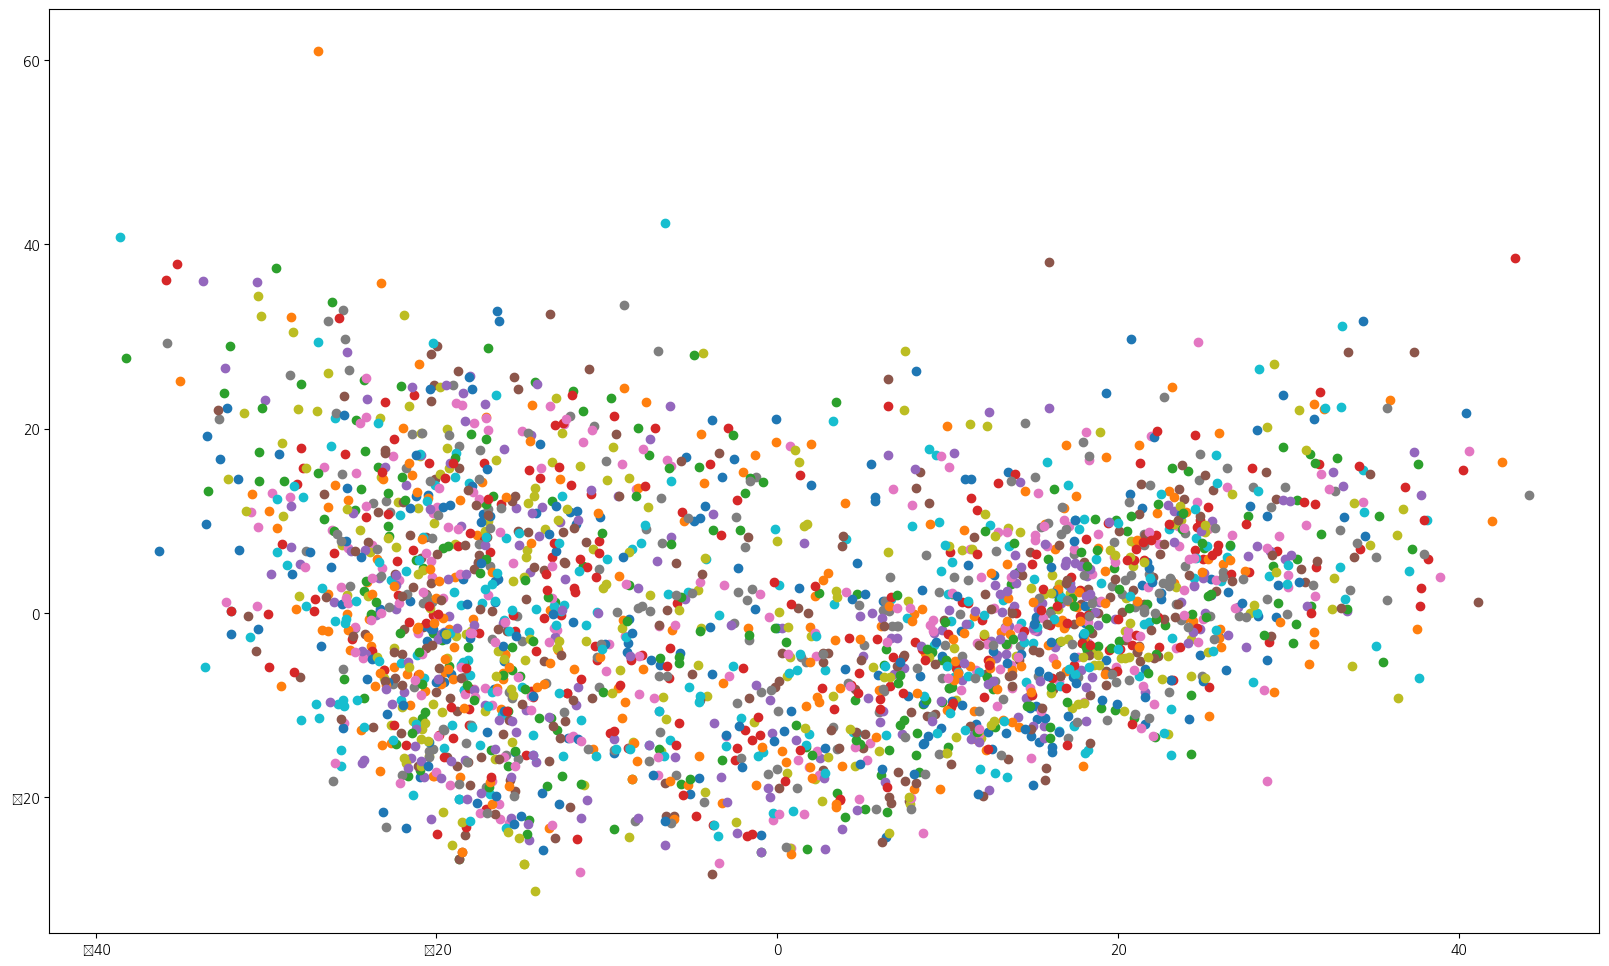

In [17]:
# 시각화
plt.figure(figsize=(20, 12))
for i in range(len(reduced_features)):
    plt.scatter(reduced_features[i, 0], reduced_features[i, 1])
plt.show()

In [ ]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import warnings
warnings.filterwarnings('ignore')

# KMeans 모델 초기화
model = KMeans(random_state=430)
visualizer = KElbowVisualizer(model, k=(20,50))

# KElbowVisualizer로 최적의 k값 찾기
visualizer.fit(features_vgg)
visualizer.show()

# 최적의 k값 저장
optimal_k = visualizer.elbow_value_
print(f"Optimal number of clusters: {optimal_k}")

In [ ]:
# 최적의 k값으로 KMeans 클러스터링 수행
kmeans = KMeans(n_clusters=optimal_k, random_state=430).fit(features)

### 유사도 측정 및 유사도 상위 5개 추천

In [100]:
import pandas as pd

df = pd.read_csv("네이버웹툰_최종.csv")
df.head()

,내용링크,제목,작가,별점,줄거리,태그,관심,이용가,몇화,이미지링크,글,그림,장르
0,/webtoon/list?titleId=758037,참교육,채용택 / 한가람,9.87,무너진 교권을 지키기 위해 교권보호국 소속 나화진의 참교육이 시작된다!<부활남> 채...,#액션#블루스트링#사이다#학원물#다크히어로#먼치킨,888507,15세 이용가,총 125화,https://image-comic.pstatic.net/webtoon/758037...,채용택,한가람,액션
1,/webtoon/list?titleId=648419,뷰티풀 군바리,설이 / 윤성원,9.81,'여자도 군대에 간다면?'본격 여자도 군대 가는 만화!,#드라마#직업드라마#밀리터리,783219,15세 이용가,총 405화,https://image-comic.pstatic.net/webtoon/648419...,설이,윤성원,드라마
2,/webtoon/list?titleId=183559,신의 탑,SIU,9.88,자신의 모든 것이었던 소녀를 쫓아 탑에 들어온 소년그리고 그런 소년을 시험하는 탑,#판타지#세계관#이능력배틀물#소년왕도물#먼치킨,1962263,12세 이용가,총 590화,https://image-comic.pstatic.net/webtoon/183559...,SIU,SIU,판타지
3,/webtoon/list?titleId=733074,백수세끼,치즈,9.85,백수 시절 내 곁을 지켜줬던 그녀... 돌아와 주면 안 되겠니?음식 메뉴마다 담겨 ...,#드라마#음식&요리#감성드라마,484825,전체연령가,총 177화,https://image-comic.pstatic.net/webtoon/733074...,치즈,치즈,드라마
4,/webtoon/list?titleId=774866,똑 닮은 딸,이담,9.98,"'우리 엄마가 살인마인 것 같다.' 성적 우수, 품행 단정, 모범적인 자식인 길소명...",#스릴러#2020 지상최대공모전#서스펜스,495954,15세 이용가,총 104화,https://image-comic.pstatic.net/webtoon/774866...,이담,이담,스릴러


In [101]:
df['고유코드'] = df['내용링크'].str.split('=').str[-1]
df['고유코드'].head()

0    758037
1    648419
2    183559
3    733074
4    774866
Name: 고유코드, dtype: object

In [ ]:
# 클러스터 레이블 저장
df['cluster'] = kmeans.labels_
df['cluster'].value_counts()

In [102]:
def recommend_similar_images(input_img_path, top_n=5):
    input_image = load_image(input_img_path)
    input_feature = vgg(input_image)
    input_feature = input_feature.view(input_feature.size(0), -1).cpu().data.numpy()
    
    # input_feature의 shape 확인
    print("input_feature shape:", input_feature.shape)  # 이를 통해 input_feature의 차원을 확인할 수 있습니다.
    
    # 필요한 경우 input_feature의 shape을 변경합니다.
    # 예: input_feature = input_feature.reshape(1, -1)
    
    distances = []
    batch_size = 100
    num_batches = len(features) // batch_size + 1
    
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size
        batch_features = features[start_idx:end_idx]
        
        # 배치 단위로 유사도 계산
        batch_distances = np.linalg.norm(batch_features - input_feature, axis=1)
        distances.extend(batch_distances)
    
    sorted_indices = np.argsort(distances)
    closest_images = [img_list[i] for i in sorted_indices[:top_n]]
    
    return closest_images


def get_image_path_from_title(title, df):
    # 웹툰 이름에 해당하는 행을 찾아 '고유코드' 반환
    row = df[df['제목'] == title]
    if len(row) == 0:
        return None
    webtoon_code = row.iloc[0]['고유코드']

    # '고유코드'를 사용하여 이미지 경로 생성
    matching_images = [img for img in img_list if f"_{webtoon_code}.jpg" in img]
    if not matching_images:
        return None
    return matching_images[0]  # 첫 번째 일치하는 이미지 경로 반환

def recommend_by_webtoon_title(title, df, top_n=5):
    # 웹툰 이름에 해당하는 이미지 경로 찾기
    input_img_path = get_image_path_from_title(title, df)
    if not input_img_path:
        print(f"'{title}'에 해당하는 웹툰 이미지를 찾을 수 없습니다.")
        return

    # 해당 이미지를 기반으로 비슷한 이미지 추천
    recommended_images = recommend_similar_images(input_img_path, top_n=top_n)

    # 추천된 이미지들 시각화
    fig, axes = plt.subplots(1, len(recommended_images), figsize=(15, 5))
    for ax, img_path in zip(axes, recommended_images):
        img = Image.open(img_path)
        img = img.resize((int(img.width * 0.8), int(img.height * 0.8)))  # 이미지를 80%로 축소
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [98]:
webtoon_title = "마음의소리"
recommend_by_webtoon_title(webtoon_title, df)

input_feature shape: (1, 25088)


ValueError: operands could not be broadcast together with shapes (100,262144) (1,25088) 

In [ ]:
webtoon_code = df[df['제목'] == '신의 탑'].iloc[0]['고유코드']
matching_images = [img for img in img_list if f"_{webtoon_code}.jpg" in img]
print(matching_images)


## 클러스터 시각화
1. 2D, 3D (점)
2. 클러스터 레이블 빈도
3. 클러스터 2개 추출 후 시각화 (이미지)
4. 클러스터 1개 시각화 (이미지)



#### 2D, 3D (점)

In [ ]:
# 2D 시각화
pca_2d = PCA(n_components=2)
reduced_features_2d = pca_2d.fit_transform(features)
reduced_cluster_centers_2d = pca_2d.transform(kmeans.cluster_centers_)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_features_2d[:, 0], reduced_features_2d[:, 1], c=kmeans.labels_, cmap='rainbow', s=100, alpha=0.5)
plt.scatter(reduced_cluster_centers_2d[:, 0], reduced_cluster_centers_2d[:, 1], color='black', marker='X', s=300)
plt.title("2D KMeans Clustering Visualization")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [ ]:
# 3D 시각화
pca_3d = PCA(n_components=3)
reduced_features_3d = pca_3d.fit_transform(features)
reduced_cluster_centers_3d = pca_3d.transform(kmeans.cluster_centers_)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_features_3d[:, 0], reduced_features_3d[:, 1], reduced_features_3d[:, 2], c=kmeans.labels_, cmap='rainbow', s=100, alpha=0.5)
ax.scatter(reduced_cluster_centers_3d[:, 0], reduced_cluster_centers_3d[:, 1], reduced_cluster_centers_3d[:, 2], color='black', marker='X', s=300)
ax.set_title("3D KMeans Clustering Visualization")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_zlabel("Principal Component 3")
plt.show()

#### 클러스터 레이블 빈도

In [ ]:
from collections import Counter

# 클러스터 레이블의 빈도 계산
cluster_counts = Counter(kmeans.labels_)

# 결과 출력
for cluster, count in cluster_counts.items():
    print(f"Cluster {cluster}: {count} images")

#### 클러스터 2개 시각화

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# 두 개의 클러스터 인덱스 추출
cluster_idx_1 = np.where(kmeans.labels_ == 5)[0]
cluster_idx_2 = np.where(kmeans.labels_ == 3)[0]

# 각 클러스터의 2D 좌표 추출
cluster_features_1 = [features[i] for i in cluster_idx_1]
cluster_features_2 = [features[i] for i in cluster_idx_2]
reduced_features_1 = pca_2d.transform(cluster_features_1)
reduced_features_2 = pca_2d.transform(cluster_features_2)

def add_border(input_image, border_color, border_size=10):
    """이미지에 테두리 추가"""
    img_with_border = Image.new('RGB', (input_image.width + 2 * border_size, input_image.height + 2 * border_size), border_color)
    img_with_border.paste(input_image, (border_size, border_size))
    return img_with_border

# 2D 공간에 이미지 시각화 함수
def plot_images_on_2d(ax, cluster_idx, reduced_features, border_color):
    for i, idx in enumerate(cluster_idx):
        img_path = img_list[idx]
        img = Image.open(img_path)
        img = img.resize((100, 100), Image.BILINEAR)
        img = add_border(img, border_color, border_size=5)  # 이미지에 테두리 추가
        img_array = np.array(img)
        x, y = reduced_features[i]
        imagebox = OffsetImage(img_array, zoom=0.5)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)
        ax.scatter(x, y)

fig, ax = plt.subplots(figsize=(20, 12))
plot_images_on_2d(ax, cluster_idx_1, reduced_features_1, 'blue')  # 클러스터 1은 파란색으로 표시
plot_images_on_2d(ax, cluster_idx_2, reduced_features_2, 'red')   # 클러스터 2는 빨간색으로 표시

ax.set_title("2D Visualization of Cluster 1 and Cluster 2 Images")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
plt.show()

#### 클러스터 1개 시각화(이미지)

In [ ]:
def plot_single_cluster_images_on_2d(ax, cluster_idx, reduced_features):
    for idx, coords in zip(cluster_idx, reduced_features):
        img_path = img_list[idx]
        img = Image.open(img_path)
        img = img.resize((100, 100), Image.BILINEAR)
        img_array = np.array(img)
        x, y = coords
        imagebox = OffsetImage(img_array, zoom=0.5)
        ab = AnnotationBbox(imagebox, (x, y), frameon=False)
        ax.add_artist(ab)

# 특정 클러스터 (예: 클러스터 1)에 속하는 이미지들의 인덱스 추출
cluster_idx_1 = np.where(kmeans.labels_ == 13)[0]

# 해당 이미지들의 2D 좌표 추출
reduced_features_2d_1 = pca_2d.transform([features[i] for i in cluster_idx_1])

# 2D 공간에 클러스터 1의 이미지들만 시각화
fig, ax = plt.subplots(figsize=(10, 6))
plot_single_cluster_images_on_2d(ax, cluster_idx_1, reduced_features_2d_1)

# x축과 y축의 범위 설정
x_values = reduced_features_2d_1[:, 0]
y_values = reduced_features_2d_1[:, 1]
ax.set_xlim(min(x_values), max(x_values))
ax.set_ylim(min(y_values), max(y_values))

ax.set_title("2D Visualization of Cluster 13 Images")
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
plt.show()


In [ ]:
# 그냥 일렬로 나열
def display_images_in_cluster(cluster_idx, img_size=(100, 100), max_images=20):
    cluster_idx = cluster_idx[:max_images]
    n_images = len(cluster_idx)
    sqrt_n = int(np.ceil(np.sqrt(n_images)))  # 이미지를 정사각형 형태로 나열하기 위해 제곱근 계산

    fig, axes = plt.subplots(sqrt_n, sqrt_n, figsize=(20, 20))

    for ax, idx in zip(axes.ravel(), cluster_idx):
        img_path = img_list[idx]
        img = Image.open(img_path)
        img = img.resize(img_size)
        ax.imshow(img)
        ax.axis('off')  # 축 정보 제거

    # 남은 subplot 공간 숨기기
    #for i in range(n_images, sqrt_n*sqrt_n):
    #    axes.ravel()[i].axis('off')

    plt.show()

# 클러스터 1에 속하는 이미지들 표시
cluster_idx_1 = np.where(kmeans.labels_ == 3)[0]
display_images_in_cluster(cluster_idx_1, img_size=(100, 100))


## 터짐 주의 (t-SNE)

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

# t-SNE를 사용해 2D로 차원축소
features = np.array(features).reshape(len(features), -1)
features_2D = TSNE(n_components=2).fit_transform(features)

def plot_images(images, coords, labels):
    fig, ax = plt.subplots(figsize=(20, 20))
    for img, (x, y), label in zip(images, coords, labels):
        im = OffsetImage(plt.imread(img), zoom=0.5)
        ab = AnnotationBbox(im, (x, y), xycoords='data', frameon=False, boxcoords="axes fraction")
        ax.add_artist(ab)
        ax.text(x, y, str(label), color='red')
    ax.update_datalim(coords)
    ax.autoscale()
    plt.show()

plot_images(img_list, features_2D, kmeans.labels_)